# Multi-View Clustering

This dataset was chosen because it is easily clusterable as it reflects weather related damages which are highly dependent upon location. We hope to see whether certain dimensions of weather related damages such as those based on temperature or distance from ocean can be captured via clustering.

The goal of this project is to determine the whether PCA can be used as a means of selecting specific subsets of a dataset to perform clustering upon.

The inspiriation for this project came from stumbling across this paper (https://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf) which explains that PCA is a continuous version of KMeans.

As PCA is a means of identifying latent features within a dataset, I was curious if one could take one of these latent features and identify discrete sets the data tends to cluster along that specific PC. I decided the most natural way to approach this would be to scale each column by the values of a given principle component and then perform clustering on all the scaled features after that. Success will be determined if different principle componenets lead to meaningfully different sets of clusters across the dataset.

## Loading Libraries

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

# Data Preparation

We begin by selecting the specific scores and features we want to focus on.

In [215]:
# Loading the data
nri_df = pd.read_csv("NRI_Table_Counties.csv")

# Selecting only the columns we want to use
selected_columns_old = ['COUNTYFIPS','STATE', 'POPULATION', 'AREA','BUILDVALUE', 'AGRIVALUE', 
                    'RISK_SCORE', 'EAL_SCORE', 'SOVI_SCORE', 'RESL_SCORE', 'AVLN_RISKS',
                    'CFLD_RISKS', 'CWAV_RISKS', 'DRGT_RISKS', 'ERQK_RISKS', 'HAIL_RISKS', 
                    'HWAV_RISKS', 'HRCN_RISKS', 'ISTM_RISKS', 'LNDS_RISKS', 'LTNG_RISKS',
                    'RFLD_RISKS', 'SWND_RISKS', 'TRND_RISKS', 'TSUN_RISKS', 'VLCN_RISKS', 
                    'WFIR_RISKS', 'WNTW_RISKS']

selected_columns_new = ['STCOFIPS', 
                    'RISK_SCORE', 'EAL_SCORE', 'SOVI_SCORE', 'RESL_SCORE', 
                    'CWAV_RISKS', 'DRGT_RISKS', 'ERQK_RISKS', 'HAIL_RISKS', 
                    'HWAV_RISKS', 'HRCN_RISKS', 'ISTM_RISKS', 'LNDS_RISKS', 'LTNG_RISKS',
                    'RFLD_RISKS', 'SWND_RISKS', 'TRND_RISKS', 
                    'WFIR_RISKS', 'WNTW_RISKS']

nri_df = nri_df[selected_columns_new]

In [216]:
# Filling in missing values with 0
for col in nri_df.columns:
    nri_df[col] = nri_df[col].fillna(0)

# Checking that all values are handled
for col in nri_df.columns:
    print(f"{col}: {sum(nri_df[col].isnull())}")


# Applying log transform to all features except STCOFIPS
for col in nri_df.columns:
    if col != 'STCOFIPS':
        nri_df[col] = np.log(nri_df[col] + 0.0001)

STCOFIPS: 0
RISK_SCORE: 0
EAL_SCORE: 0
SOVI_SCORE: 0
RESL_SCORE: 0
CWAV_RISKS: 0
DRGT_RISKS: 0
ERQK_RISKS: 0
HAIL_RISKS: 0
HWAV_RISKS: 0
HRCN_RISKS: 0
ISTM_RISKS: 0
LNDS_RISKS: 0
LTNG_RISKS: 0
RFLD_RISKS: 0
SWND_RISKS: 0
TRND_RISKS: 0
WFIR_RISKS: 0
WNTW_RISKS: 0


In [217]:
# Loading Location Data
location_df = pd.read_csv("uscounties.csv")

# Converting features to numeric
location_df["county_fips"] = pd.to_numeric(location_df["county_fips"])
location_df["lat"] = pd.to_numeric(location_df["lat"])
location_df["lng"] = pd.to_numeric(location_df["lng"])

# Selecting only the columns we want to use
location_df = location_df[["county_fips", "lat", "lng"]]

# Combining the data joining on the county fips
counties_df = nri_df.set_index("STCOFIPS").join(location_df.set_index("county_fips"))   

# Removing NaN values
counties_df = counties_df.dropna()

nri_df = counties_df.drop(['lng', 'lat'], axis=1)

In [218]:
nri_df.describe()

,RISK_SCORE,EAL_SCORE,SOVI_SCORE,RESL_SCORE,CWAV_RISKS,DRGT_RISKS,ERQK_RISKS,HAIL_RISKS,HWAV_RISKS,HRCN_RISKS,ISTM_RISKS,LNDS_RISKS,LTNG_RISKS,RFLD_RISKS,SWND_RISKS,TRND_RISKS,WFIR_RISKS,WNTW_RISKS
count,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,2.202533,2.463807,3.594282,3.998496,-1.694429,0.240448,0.741399,1.946464,-1.022195,-1.686545,1.763836,2.058803,2.193023,1.769812,2.275248,2.491133,0.951001,2.166487
std,0.614314,0.502089,0.383363,0.054429,5.898706,4.240762,1.057553,1.146928,5.074964,4.895212,2.358487,1.751400,1.356636,1.712001,1.160937,0.828983,1.990478,1.976044
min,-9.210340,-3.991522,-4.595220,3.718183,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340,-9.210340
25%,1.900479,2.174494,3.462235,3.963664,-9.210340,0.986082,0.085963,1.616341,-9.210340,-9.210340,1.742813,1.915185,1.980146,1.566630,2.078652,2.196710,0.379417,2.122521
50%,2.207286,2.443537,3.646819,4.001145,2.422103,2.010738,0.812582,2.044878,1.830020,1.059817,2.231422,2.366482,2.357265,2.068012,2.433433,2.623456,1.163343,2.497651
75%,2.528798,2.741980,3.794636,4.038583,3.125476,2.572589,1.393602,2.487007,2.378899,1.576296,2.660852,2.705670,2.691271,2.460872,2.726176,2.981968,2.066647,2.864419
max,4.605171,4.605171,4.605171,4.169355,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171,4.605171


# Clustering without PCA

## Is the data clusterable?

We first invistage the degree to which our data can be meaningfully clustered by examing the distribution of distances between points. If our data is broken up into clusters, then we ought to see multiple peaks in the histogram.

[]

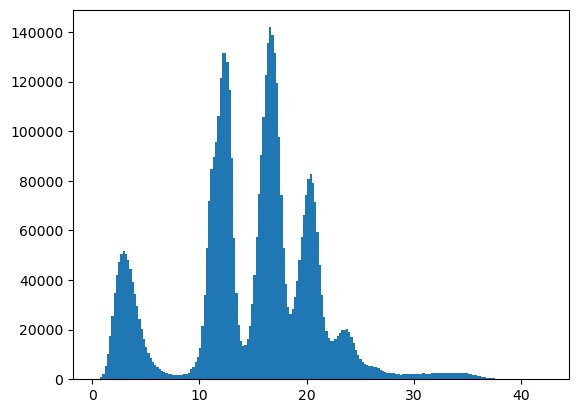

In [219]:
from scipy.spatial import distance_matrix

dist_mat = distance_matrix(nri_df, nri_df, p=2)
dist_mat = np.triu(dist_mat).flatten()
dist_mat = dist_mat[np.nonzero(dist_mat)]

plt.hist(dist_mat, bins=200)
plt.plot()

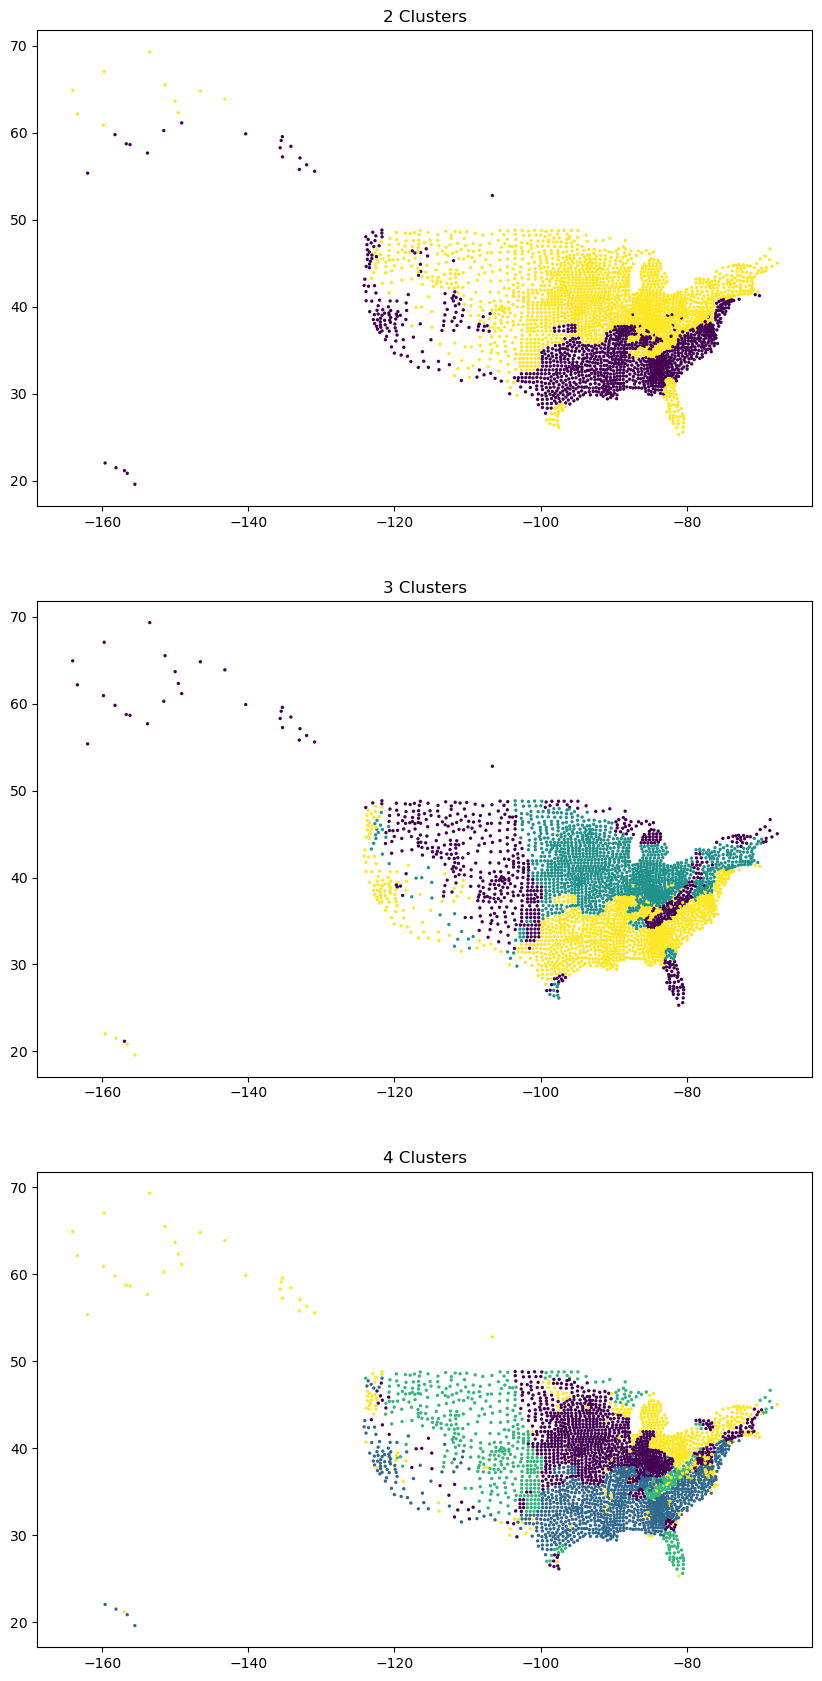

In [220]:
# KMeans Clustering

upper_bound = 5
lower_bound = 2

fig, ax = plt.subplots(upper_bound-lower_bound, ncols=1, figsize=(10, 7* (upper_bound-lower_bound)))
for num_clusters in range(lower_bound,upper_bound):
    idx = num_clusters - lower_bound
    kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(nri_df)
    ax[idx].scatter(counties_df['lng'], counties_df['lat'], c=kmeans.labels_, s=2)
    ax[idx].set_title(f"{num_clusters} Clusters")
plt.show()
    

In [221]:
kmeans = KMeans(n_clusters=6, random_state=1).fit(nri_df)

cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=counties_df.columns[:-2])

cluster_centers_df

,RISK_SCORE,EAL_SCORE,SOVI_SCORE,RESL_SCORE,CWAV_RISKS,DRGT_RISKS,ERQK_RISKS,HAIL_RISKS,HWAV_RISKS,HRCN_RISKS,ISTM_RISKS,LNDS_RISKS,LTNG_RISKS,RFLD_RISKS,SWND_RISKS,TRND_RISKS,WFIR_RISKS,WNTW_RISKS
0,1.978002,2.281147,3.580479,4.027912,2.782671,-9.210340,0.603758,1.899147,-0.798094,0.273969,2.221353,2.317731,2.394076,1.869178,2.338187,2.393261,0.054134,2.417484
1,2.177076,2.514037,3.533368,4.014731,2.876673,1.926638,0.896458,2.022786,2.070162,1.213485,2.185185,2.211022,2.347948,2.076461,2.562471,2.696573,0.437446,2.508423
2,2.423590,2.640442,3.620345,3.981669,-9.210340,1.263522,1.226315,2.001533,2.259510,0.637695,1.611283,2.203086,2.478251,2.079026,2.386706,2.765789,1.212766,2.187353
3,2.131404,2.415334,3.614372,4.042672,2.897451,2.174577,-0.245706,2.442507,1.791850,-9.210340,2.163280,1.946553,1.965434,1.326558,2.466419,2.457998,1.357143,2.737632
4,2.119008,2.304957,3.643353,3.973612,2.976738,1.537338,0.523150,1.797227,-9.203823,-5.454988,0.916968,1.953689,2.023216,1.255517,1.991287,2.056227,1.679555,1.429505
5,2.045308,2.337770,3.541650,3.959850,-9.165369,-0.042901,0.675338,1.137769,-9.149984,-1.487569,1.734022,1.100619,1.090269,1.403130,1.280587,2.010880,0.454885,1.479960


The problem with these means is that they are difficult to interpret and seem to be combining a bunch of different factors. It would be more ideal if the cluster only had a few key attributes.

## Performing PCA on the Dataset

We perform PCA on the dataset and see examine some basic features about the datset.

In [222]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

pca= PCA()

pca_df = pca.fit_transform(nri_df)

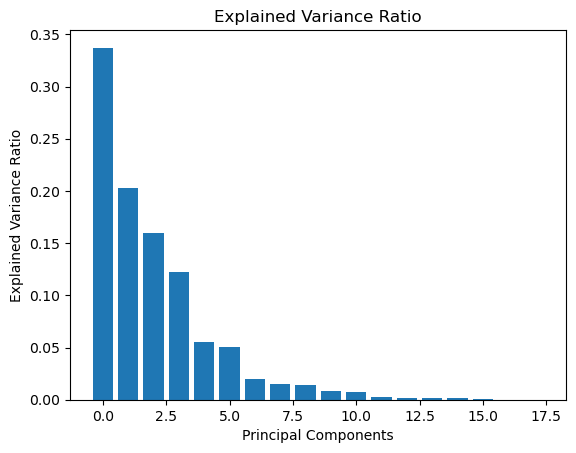

In [223]:
# create a bar plot of the explained variance ratios
fig, ax = plt.subplots()
ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio')
plt.show()

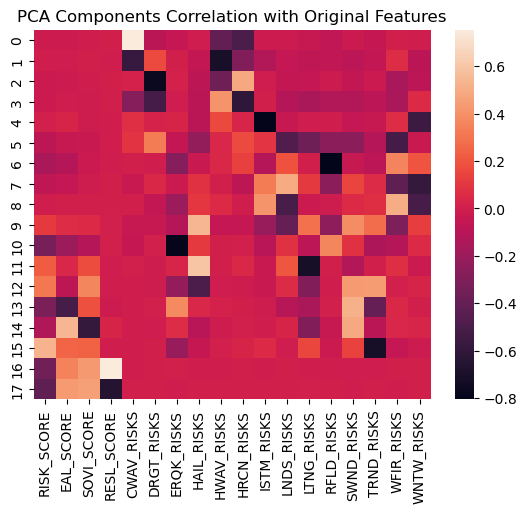

In [224]:
pca_df = pd.DataFrame(pca.components_, columns=nri_df.columns)
sns.heatmap(pca_df)
plt.title('PCA Components Correlation with Original Features')
plt.show()

Importantly, we see that the data is explained by a few key principle components AND that these componenets are only associated with a few key features. We want to see if we can exploit that fact.

## Clustering via PCA

We begin by examining the first PC and seeing what features stand out the most.

In [225]:
def imp_features(pca_i, n_features = 3):
    return pca_i[pca_i.abs().nlargest(n_features).index]


print(f"PCA {0}: \n{imp_features(pca_df.iloc[0],5)}\n")

PCA 0: 
CWAV_RISKS    0.754034
HRCN_RISKS   -0.494885
HWAV_RISKS   -0.404576
DRGT_RISKS   -0.091271
RFLD_RISKS   -0.065352
Name: 0, dtype: float64



We are now interested in whether the distribution of distances between points is different than before. This would be a good indicator that this PC is capturing something distinct.

[]

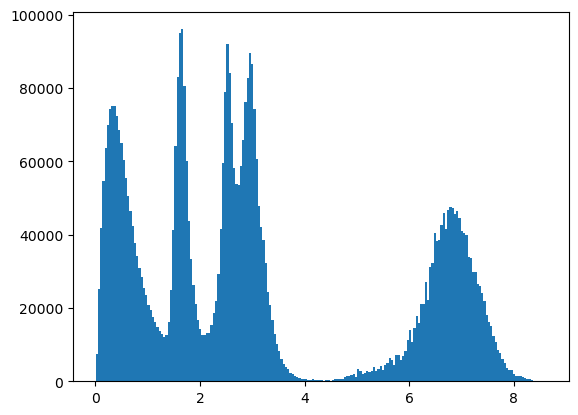

In [226]:
pca_0_df = pd.DataFrame(nri_df).apply(lambda x: x * pca_df.iloc[2][x.name]**2)

dist_mat = distance_matrix(pca_0_df, pca_0_df, p=2)
dist_mat = np.triu(dist_mat).flatten()
dist_mat = dist_mat[np.nonzero(dist_mat)]

plt.hist(dist_mat, bins=200)
plt.plot()


We notice that the distance between points looks extremely different than the initial dataset! This means we are hopefully capturing a different perspective on the dataset. We continue by visualizing what clusters are identified.

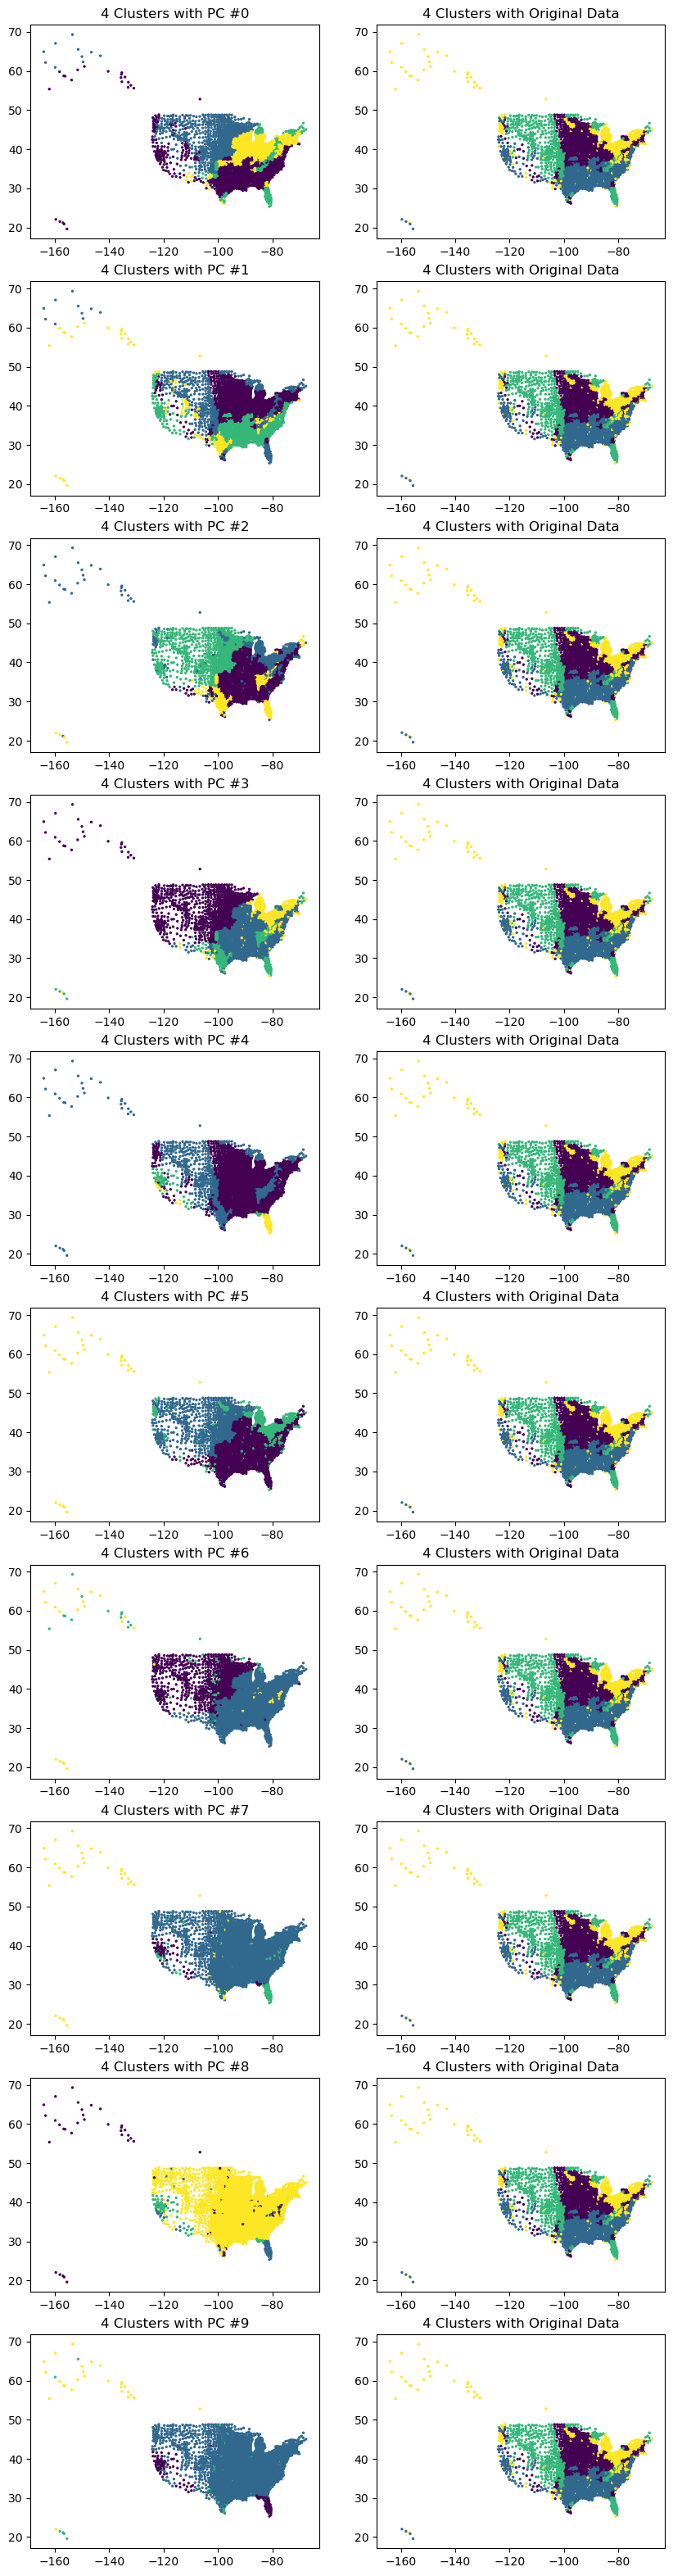

In [259]:
upper_bound = 10
lower_bound = 0



pca_i_df = pd.DataFrame(nri_df).apply(lambda x: x * pca_df.iloc[ith_pc][x.name]**2)

num_clusters=4

fig, ax = plt.subplots(upper_bound-lower_bound, ncols=2, figsize=(10, 4* (upper_bound-lower_bound)))
for ith_pc in range(lower_bound,upper_bound):
    pca_i_df = pd.DataFrame(nri_df).apply(lambda x: x * pca_df.iloc[ith_pc][x.name])
    idx = ith_pc - lower_bound

    kmeans_pca = KMeans(n_clusters=num_clusters, random_state=1).fit(pca_i_df)
    ax[idx,0].scatter(counties_df['lng'], counties_df['lat'], c=kmeans_pca.labels_, s=2)
    ax[idx,0].set_title(f"{num_clusters} Clusters with PC #{ith_pc}")

    kmeans = KMeans(n_clusters=num_clusters, random_state=1).fit(nri_df)
    ax[idx,1].scatter(counties_df['lng'], counties_df['lat'], c=kmeans.labels_, s=2)
    ax[idx,1].set_title(f"{num_clusters} Clusters with Original Data")
plt.show()

We observe that the clusters obtained through PCA have two potential advantages over clustering over the hole dataset.

First, the clusters seem to be cleaner and better defined geographically.

Second, as we go through the PCs, there is more variety in the types of clusters identified.

As an example of the potential power of this method, we look at the clusters obtained with PC #6

In [263]:
pca_i_df = pd.DataFrame(nri_df).apply(lambda x: x * pca_df.iloc[6][x.name])

kmeans_pca = KMeans(n_clusters=num_clusters, random_state=1).fit(pca_i_df)

cluster_centers_df = pd.DataFrame(kmeans_pca.cluster_centers_, columns=counties_df.columns[:-2])

for i in range(0,3):
    print(f"Cluster {i}: \n{imp_features(cluster_centers_df.iloc[i])}\n")


Cluster 0: 
RFLD_RISKS   -1.299148
HRCN_RISKS   -1.155979
WFIR_RISKS    0.596784
Name: 0, dtype: float64

Cluster 1: 
RFLD_RISKS   -1.724327
WNTW_RISKS    0.422198
LNDS_RISKS    0.419745
Name: 1, dtype: float64

Cluster 2: 
RFLD_RISKS    7.084790
HRCN_RISKS   -0.930939
WFIR_RISKS   -0.398424
Name: 2, dtype: float64



We observe that these lusters arestrongly related to the risk of flooding and hurricanes. These indicate a cluster relationship that would have been overshadowed in the original dataset.

Future work on this technique would require showing that this technique is legitimate mathematically and that it works on a variety of datasets.